In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spopt
from Wavenumbers_components import *
from cvt import *
from cvt_bfgs import *
from wavenumers_bfgs import *
import time

# Data and preprocessing

In [2]:
# Data
x_diffraction_pt = np.array([5000, -3000]) # difraction point, fixed throughout the notebook

start = 0
stop = 10000

c0 = 2000 # velocity of the medium
f0 = c0/(2*np.pi) # it's f_0; is f0 = f_0?
k0 = 2*np.pi*f0/c0

# We compute the maximum angle \phi_max that \phi_s and \phi_r can take; will be useful for 
# later angular and circular arcs formulations of the wavenumber components 
s = np.array([start, 0])
ps = x_diffraction_pt - s
ps = ps/np.linalg.norm(ps)

phi_max = np.arccos(np.inner(ps, np.array([0, -1]))) 
phi_limits = np.array([- phi_max, phi_max])
limits, empty = angles2layout(phi_limits, np.array([]), x_diffraction_pt)
phi_max_enveloppe = 1.03*phi_max
phi_limits_enveloppe = np.array([- phi_max_enveloppe, phi_max_enveloppe])

m = 10 # number of sources
n = 10 # number of receivers

W = domain_construction(phi_limits_enveloppe, k0)
W_tight = domain_construction(phi_limits, k0)

# First result

In [3]:
# reference sources and receivers
S1 = np.array([np.linspace(start = start, stop = stop, num = m, dtype = float), np.zeros(m)]).T # localizations of the sources
R1 = np.array([np.linspace(start = start, stop = stop, num = n, dtype = float), np.zeros(n)]).T # localizations

# Shifted sources and receivers
shift = np.abs( 0.25*(start - stop)/m )
S1_shifted = ( S1 + np.array([shift, 0]) )  # localizations of the sources
R1_shifted = ( R1 - np.array([shift, 0]) )  # localizations of the receivers

Phi_S, Phi_R = layout2angles(S1_shifted, R1_shifted, x_diffraction_pt)

initial_Phi = np.concatenate((Phi_S, Phi_R))

FoK(initial_Phi, W, c0, f0, m)

0.00540123837450773

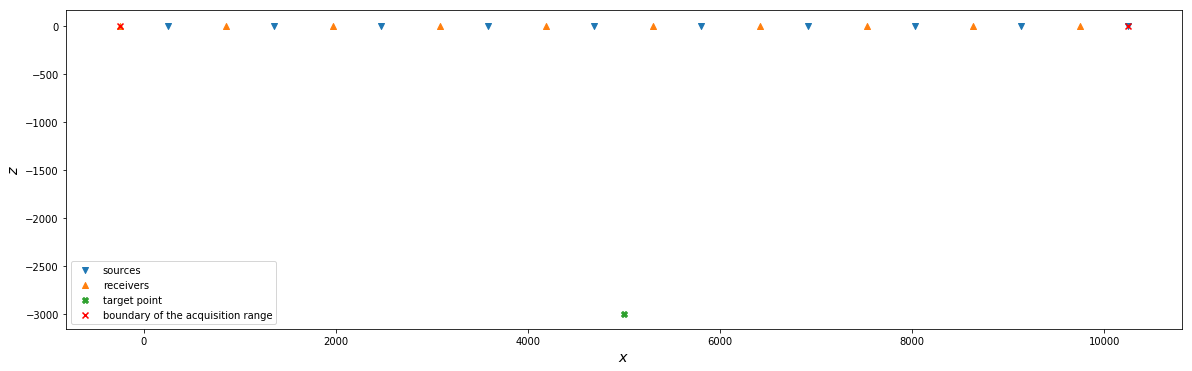

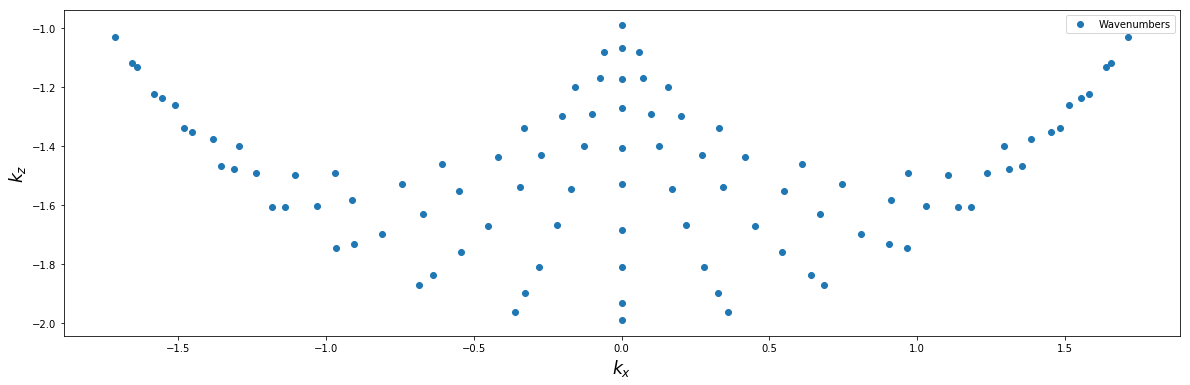

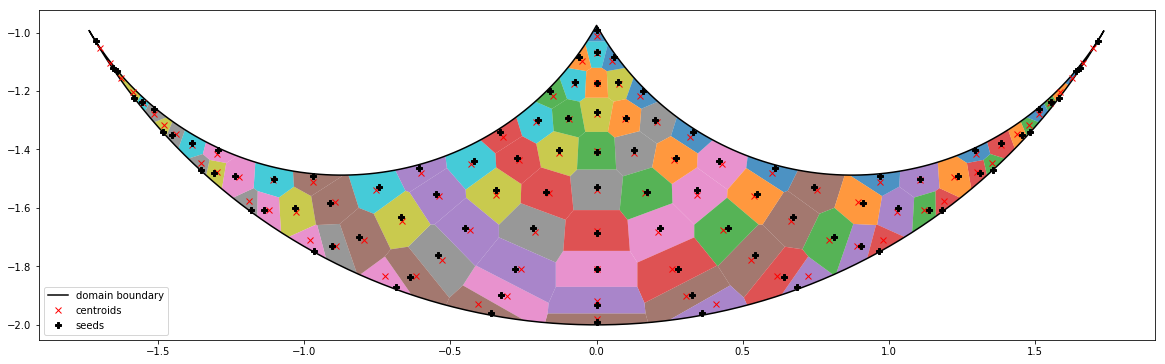

In [5]:
limits2 = np.array([[- shift, 0], [10000 + shift, 0]])
plot_disposition(S1_shifted, R1_shifted, x_diffraction_pt, limits = limits2)
K1 = wavenumbers_components_angles(Phi_S, Phi_R, c0, f0)
plot_scatter(K1, labels = "Wavenumbers")
seeds1, regions1 = voronoi_domain(K1, W)
plot_voronoi_domain(seeds1, W, regions1)

In [13]:
start_time = time.time()

bfgs1 = spopt.minimize(FoK, initial_Phi, method = 'BFGS', jac = grad_FoK, args = (W, c0, f0, m))
exec_time1 = time.time() - start_time

bfgs1

      fun: 0.0038996402219321526
 hess_inv: array([[  7.80506791,   4.12230514,   3.31828722,  -0.33641126,
         -0.09914286,   0.92957186,  -0.29354372,  -1.69991239,
         -1.68439077,   0.0452264 ,  -0.04522639,   1.68439077,
          1.6999124 ,   0.29354369,  -0.92957188,   0.09914285,
          0.3364113 ,  -3.31828721,  -4.12230516,  -6.80506792],
       [  4.12230514,  15.37294495,  10.92938676,   4.54546288,
          3.44128616,  -3.64101305,  -4.98185446,  -9.14034508,
         -4.06403231,  -0.604347  ,   0.60434701,   4.06403232,
          9.14034509,   4.98185449,   3.64101309,  -3.44128615,
         -4.54546293, -10.92938675, -14.37294495,  -4.12230513],
       [  3.31828722,  10.92938676,  22.60898147,  14.88524511,
          9.6843071 , -12.4376248 , -11.08737792, -15.46891871,
         -4.49604915,  -0.13183456,   0.13183456,   4.49604917,
         15.46891874,  11.08737799,  12.43762487,  -9.6843071 ,
        -14.8852452 , -21.60898146, -10.92938677,  -3.3182

In [26]:
print("Execution time: ", exec_time1)

Execution time:  96.86078596115112


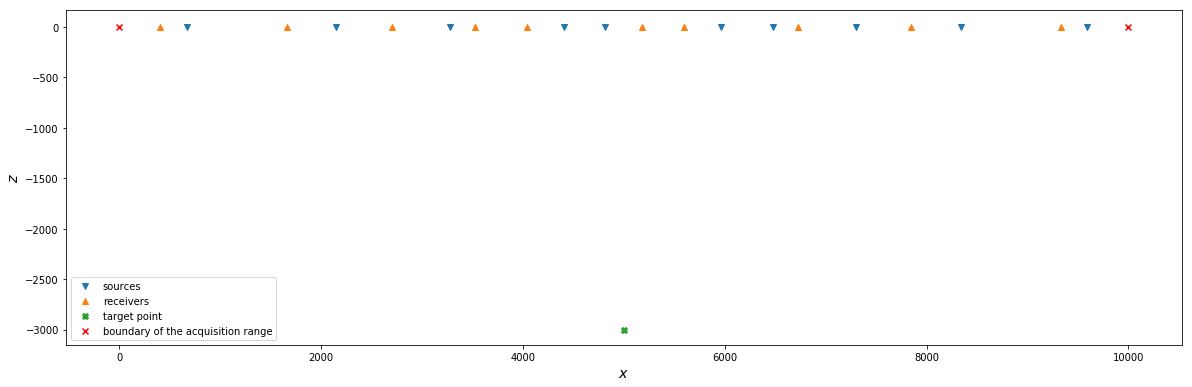

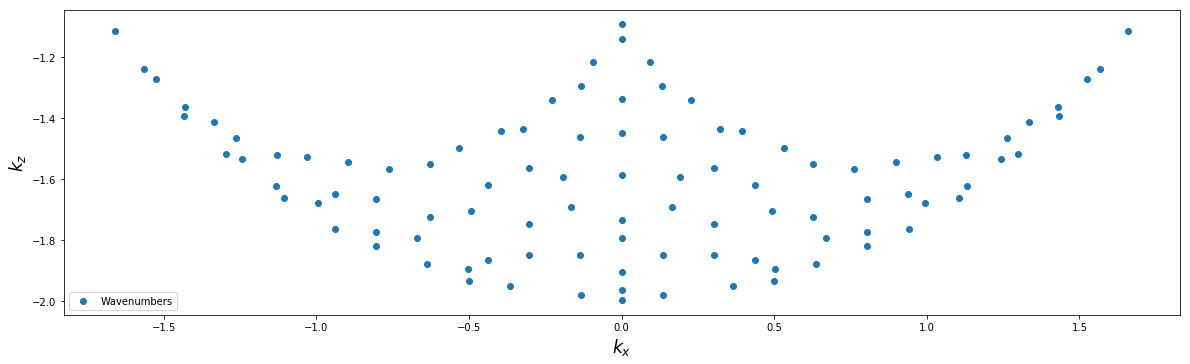

In [8]:
PhiS_bfgs1, PhiR_bfgs1 = Phi_extraction(bfgs1['x'], m)
S_bfgs1, R_bfgs1 = angles2layout(PhiS_bfgs1, PhiR_bfgs1, x_diffraction_pt)
plot_disposition(S_bfgs1, R_bfgs1, x_diffraction_pt, limits = limits)
K_bfgs1 = wavenumbers_components_angles(PhiS_bfgs1, PhiR_bfgs1, c0, f0)
plot_scatter(K_bfgs1, labels = "Wavenumbers")
bfgs1_seeds, bfgs1_regions = voronoi_domain(K_bfgs1, W)

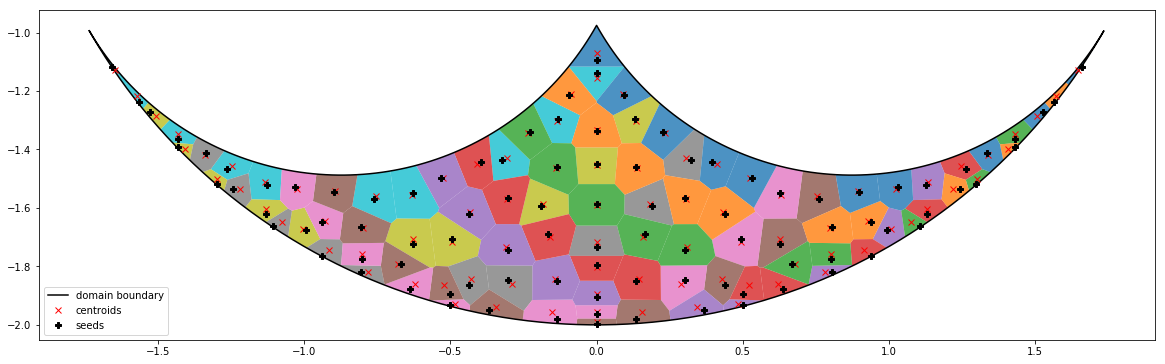

In [9]:
plot_voronoi_domain(bfgs1_seeds, W, bfgs1_regions)

## CVT

In [15]:
bfgs_cvt = spopt.minimize(F, K_bfgs1, method = 'BFGS', jac = grad_F, args = (W,), options = {'disp':True})
bfgs_cvt

Optimization terminated successfully.
         Current function value: 0.002764
         Iterations: 340
         Function evaluations: 349
         Gradient evaluations: 349


      fun: 0.0027643385252988624
 hess_inv: array([[ 14.67910838,  15.76853904,  18.36994042, ...,  17.01126095,
        -13.59723904,  15.67287129],
       [ 15.76853904,  19.41790627,  21.08616589, ...,  19.774462  ,
        -15.65040939,  18.27985947],
       [ 18.36994042,  21.08616589,  36.53207654, ...,  27.70678136,
        -18.43264454,  21.15942442],
       ...,
       [ 17.01126095,  19.774462  ,  27.70678136, ...,  38.03869594,
        -17.21218982,  20.009237  ],
       [-13.59723904, -15.65040939, -18.43264454, ..., -17.21218982,
         14.61186528, -15.66745821],
       [ 15.67287129,  18.27985947,  21.15942442, ...,  20.009237  ,
        -15.66745821,  19.27347701]])
      jac: array([ 2.48635892e-06,  3.31399172e-06, -3.06029648e-07, -6.95529209e-08,
       -1.22424461e-06,  1.97985487e-06,  8.40144740e-06,  2.28180151e-07,
       -9.09378865e-06,  1.78316875e-06, -9.69969484e-06,  5.83198526e-06,
        1.29677381e-06,  4.64579679e-06,  3.96760825e-06,  6.11808289e-

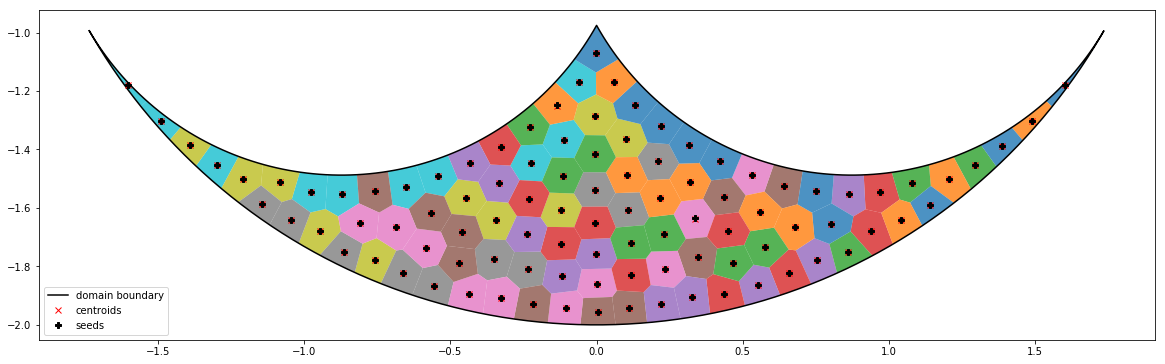

In [17]:
cvt_seeds, cvt_regions = voronoi_domain(bfgs_cvt['x'], W)
plot_voronoi_domain(cvt_seeds, W, cvt_regions)

## Different initializations

### uniform random layouts

In [18]:
N = 10
random_S = []
random_R = []
random_SR_initial = []
random_SR_bfgs = []
random_SR_exec_time = []
for i in range(N):
    random_S.append( np.array( [np.random.uniform(start, stop, size = m), np.zeros(m) ] ).T )
    random_R.append( np.array( [np.random.uniform(start, stop, size = n), np.zeros(n) ] ).T )
    PhiS, PhiR = layout2angles(random_S[i], random_R[i], x_diffraction_pt)
    initial_Phi = np.concatenate((PhiS, PhiR))
    
    random_SR_initial.append( FoK(initial_Phi, W, c0, f0, m) )
    
    start_time = time.time()
    random_SR_bfgs.append( spopt.minimize(FoK, initial_Phi, method = 'BFGS', jac = grad_FoK, args = (W, c0, f0, m)))  
    random_SR_exec_time.append(time.time() - start_time)

In [19]:
random_SR_initial = np.array( random_SR_initial )  
print("=============== Random Uniform positioning ============")
print('Initial values')
#print(random_SR_initial)
print('average : ', np.mean(random_SR_initial) )

print('Value of F')
random_SR_F = []
for i in range(N):
    random_SR_F.append( random_SR_bfgs[i]['fun'])
random_SR_F = np.array( random_SR_F )
print(random_SR_F < bfgs1['fun'] )
print('average : ', np.mean(random_SR_F))
print('min : ', np.min(random_SR_F))
print('max : ', np.max(random_SR_F))

print('Number of iterations')
random_SR_nit = []
for i in range(N):
    random_SR_nit.append( random_SR_bfgs[i]['nit'])
random_SR_nit = np.array( random_SR_nit )
#print(random_SR_nit)
print('average : ', np.mean(random_SR_nit))

print('Number of function evaluations')
random_SR_nfev = []
for i in range(N):
    random_SR_nfev.append( random_SR_bfgs[i]['nfev'])
random_SR_nfev = np.array( random_SR_nfev )
#print(random_SR_nfev)
print('average : ', np.mean(random_SR_nfev))

print('Execution time')

print('average : ', np.mean(random_SR_exec_time))

=============== Random Uniform positioning ============
Initial values
average :  0.013390529478850074
Value of F
[False False  True False  True  True False  True  True  True]
average :  0.0037639281649907213
min :  0.0034691120337556228
max :  0.003935078162936367
Number of iterations
average :  88.0
Number of function evaluations
average :  93.6
Execution time
average :  140.65845894813538


### uniform random angles

In [16]:
N = 10
random_Phi = []
random_Phi_initial = []
random_Phi_bfgs = []
random_Phi_exec_time = []
for i in range(N):
    random_Phi.append( np.random.uniform(- phi_max, phi_max, size = m + n) )
    initial_Phi = random_Phi[i]
    
    random_Phi_initial.append( FoK(initial_Phi, W, c0, f0, m) )
    start_time = time.time()
    random_Phi_bfgs.append( spopt.minimize(FoK, initial_Phi, method = 'BFGS', jac = grad_FoK, args = (W, c0, f0, m)))
    random_Phi_exec_time.append(time.time() - start_time)

In [20]:
random_Phi_initial = np.array( random_Phi_initial )    

In [27]:
random_Phi_initial = np.array( random_Phi_initial )  
print("=============== Random Uniform positioning ============")
print('Initial values')
print(random_Phi_initial)
print(np.mean(random_Phi_initial))

print('Value of F')
random_Phi_F = []
for i in range(N):
    random_Phi_F.append( random_Phi_bfgs[i]['fun'])
random_Phi_F = np.array( random_Phi_F )
print(random_Phi_F < bfgs1['fun'])
print(random_Phi_F)
print('average : ', np.mean(random_Phi_F))
print('min : ', np.min(random_Phi_F))
print('max : ', np.max(random_Phi_F))

print('Number of iterations')
random_Phi_nit = []
for i in range(N):
    random_Phi_nit.append( random_Phi_bfgs[i]['nit'])
random_Phi_nit = np.array( random_Phi_nit )
#print(random_Phi_nit)
print('average : ', np.mean(random_Phi_nit))

print('Number of function evaluations')
random_Phi_nfev = []
for i in range(N):
    random_Phi_nfev.append( random_Phi_bfgs[i]['nfev'])
random_Phi_nfev = np.array( random_Phi_nfev )
#print(random_Phi_nfev)
print('average : ', np.mean(random_Phi_nfev))

print('Execution time')

print('average : ', np.mean(random_Phi_exec_time))

=============== Random Uniform positioning ============
Initial values
[0.00808062 0.00800411 0.02661576 0.01418093 0.0126906  0.01206309
 0.01611619 0.01185608 0.01001125 0.01227943]
0.01318980668646547
Value of F
[ True False False False  True False  True  True False  True]
[0.0034442  0.00405605 0.00391942 0.00391356 0.00342376 0.00394921
 0.00333412 0.00373302 0.00392973 0.00370046]
average :  0.0037403537928156795
min :  0.0033341222338643403
max :  0.004056054505457681
Number of iterations
average :  90.3
Number of function evaluations
average :  94.0
Execution time
average :  145.70177042484283


### Regular angles

In [22]:
Phi = np.linspace(start = -phi_max, stop = phi_max, num = n + m)
phiS_regular_shifted = Phi[0::2]
phiR_regular_shifted = Phi[1::2]

# Choose which acquisition to select as initialization
initial_Phi = np.concatenate((phiS_regular_shifted, phiR_regular_shifted))
print(FoK(initial_Phi, W, c0, f0, m))

0.004995020653579053


In [23]:
start_time = time.time()
bfgs_angles = spopt.minimize(FoK, initial_Phi, method = 'BFGS', jac = grad_FoK, args = (W, c0, f0, m))
exec_time_angles = time.time() - start_time

In [24]:
print("Execution time: ", exec_time_angles)
bfgs_angles

Execution time:  120.80125570297241


      fun: 0.00390396129338313
 hess_inv: array([[ 3.53373200e+00,  2.11793758e+00,  2.23925024e+00,
         7.88585692e-01,  9.74940727e-01,  1.78348985e-01,
        -1.16900206e-01, -1.61556497e+00, -1.74823044e+00,
        -1.12474678e-02,  1.32242610e-02,  1.74735860e+00,
         1.61160937e+00,  1.22632370e-01, -1.78167570e-01,
        -9.85498682e-01, -7.82299877e-01, -2.23855674e+00,
        -2.11547848e+00, -2.53481018e+00],
       [ 2.11793758e+00,  9.66648695e+00,  6.46716753e+00,
         4.27935136e+00,  2.06888557e+00,  1.01708668e+00,
        -4.31982820e+00, -7.27135779e+00, -5.22653767e+00,
        -2.99854329e+00,  3.00602102e+00,  5.22512906e+00,
         7.25599753e+00,  4.34955701e+00, -1.01544374e+00,
        -2.11652903e+00, -4.25752043e+00, -6.46807079e+00,
        -8.65845541e+00, -2.12383535e+00],
       [ 2.23925024e+00,  6.46716753e+00,  1.75594592e+01,
         9.50456545e+00,  3.83695879e+00,  1.91956588e+00,
        -1.14695706e+01, -1.57666025e+01, -8.3

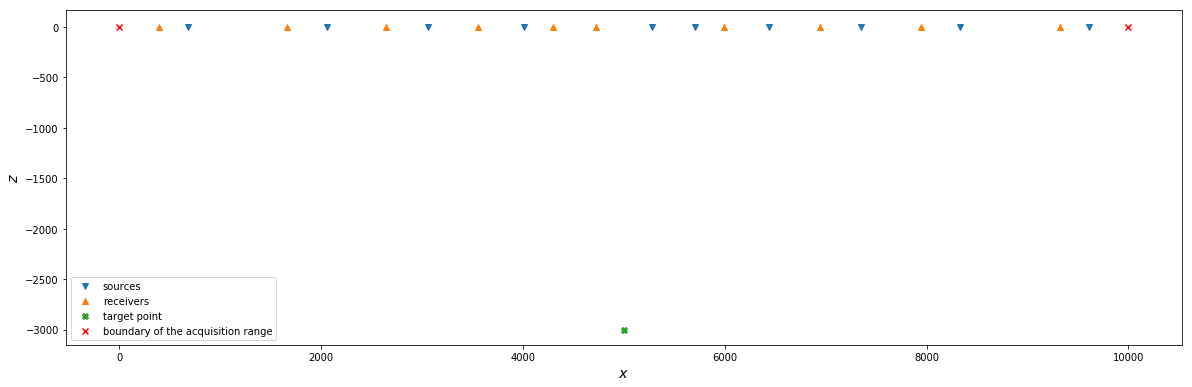

No handles with labels found to put in legend.


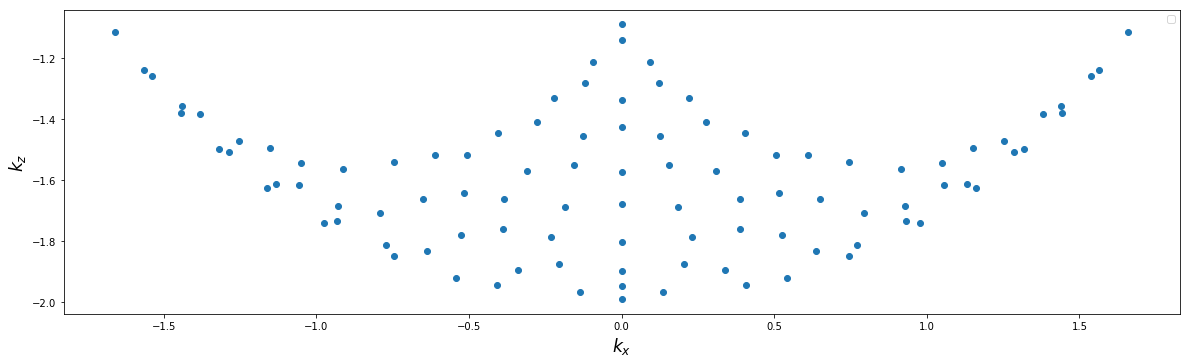

In [25]:
PhiS_angles, PhiR_angles = Phi_extraction(bfgs_angles['x'], m)
S_angles, R_angles = angles2layout(PhiS_angles, PhiR_angles, x_diffraction_pt)
plot_disposition(S_angles, R_angles, x_diffraction_pt, limits = limits)
K_angles = wavenumbers_components_angles(PhiS_angles, PhiR_angles, c0, f0)
plot_scatter(K_angles, labels = "")
angles_seeds, angles_regions = voronoi_domain(K_angles, W)

### Initializations

In [ ]:
plot_disposition(random_S[0], random_R[0], x_diffraction_pt, limits = limits)
PhiS, PhiR = layout2angles(random_S[0], random_R[0], x_diffraction_pt)
K = wavenumbers_components_angles(PhiS, PhiR, c0, f0)
plot_scatter(K, labels = " ")

In [ ]:
PhiS = random_Phi[1][:m]
PhiR = random_Phi[1][m:]
S, R = angles2layout(PhiS, PhiR, x_diffraction_pt)
plot_disposition(S, R, x_diffraction_pt, limits = limits)
K = wavenumbers_components_angles(PhiS, PhiR, c0, f0)
plot_scatter(K, labels = "")

### Best result so far

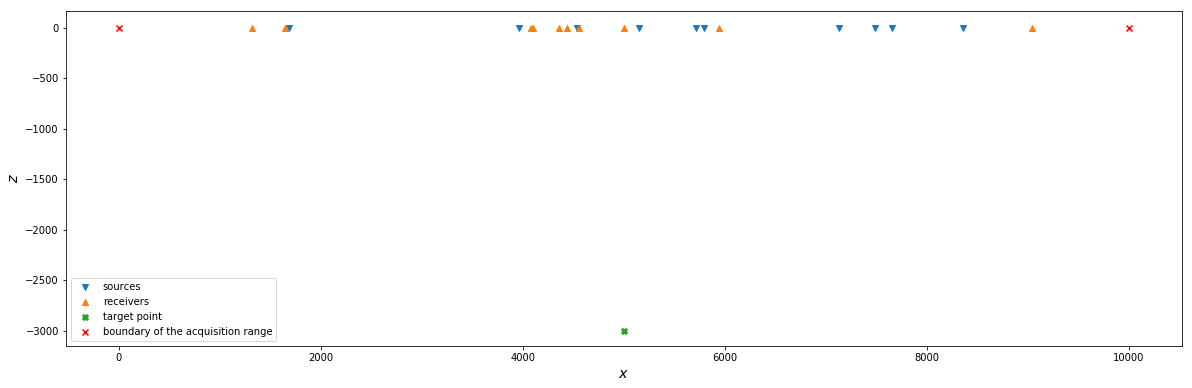

No handles with labels found to put in legend.


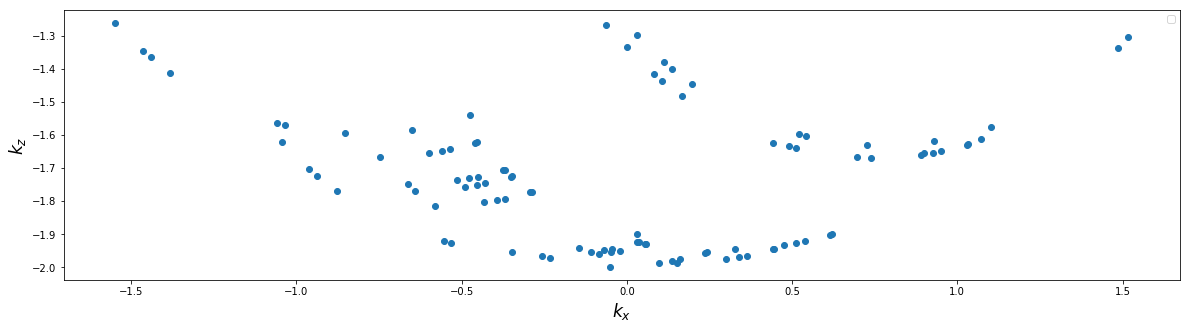

In [29]:
PhiSi = random_Phi[6][:m]
PhiRi = random_Phi[6][m:]
S_i, R_i = angles2layout(PhiSi, PhiRi, x_diffraction_pt)
plot_disposition(S_i, R_i, x_diffraction_pt, limits = limits)
K_i = wavenumbers_components_angles(PhiSi, PhiRi, c0, f0)
plot_scatter(K_i, labels = "")

In [32]:
FoK(random_Phi[6], W, c0, f0, m)

0.01611619369418685

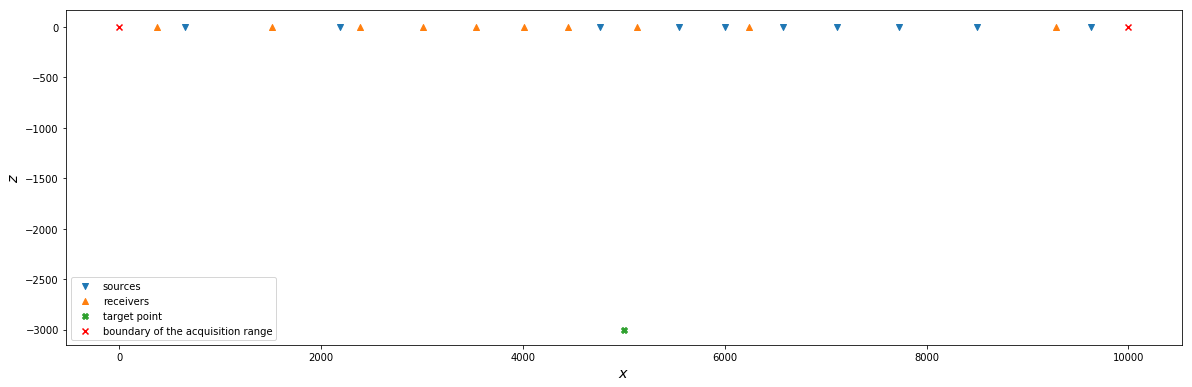

No handles with labels found to put in legend.


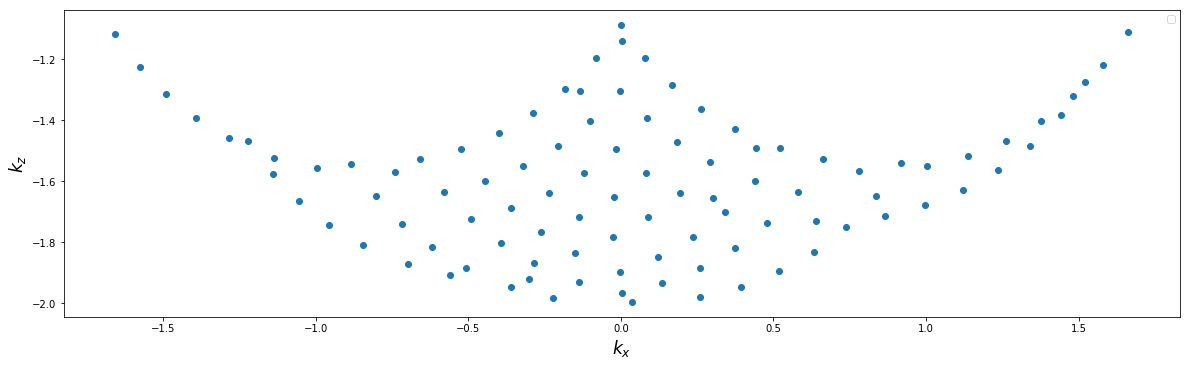

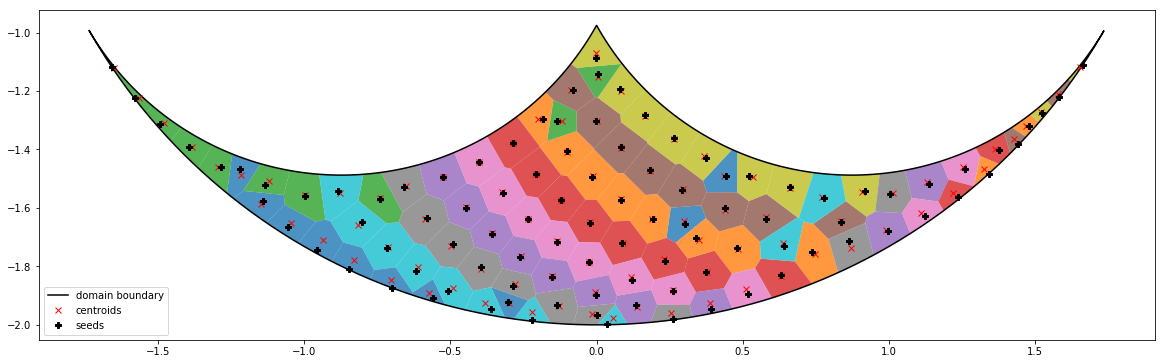

      fun: 0.0033341222338643403
 hess_inv: array([[ 1.57294622e+01, -1.39420764e+00, -7.34160396e+00,
         1.05380738e+01,  1.02593961e+01, -4.16191876e+00,
        -5.56276144e+00,  3.61620297e+00,  7.23201095e+00,
         7.13963575e-01,  7.27248689e+00, -3.04414306e+00,
        -2.99785835e-01, -3.75766574e+00, -6.64220691e+00,
        -1.20577785e+00, -4.97784650e+00, -7.04261462e+00,
         1.45880807e-01, -3.58153443e+00],
       [-1.39420764e+00,  1.49276882e+01, -7.45593990e-01,
        -2.00391076e-01, -1.85364419e+00, -5.90480540e+00,
        -6.44116548e+00, -1.76070701e+00,  2.23379055e+00,
         7.53034530e+00,  2.85449528e+00, -3.55265304e+00,
         1.90070648e+00, -6.62986881e+00, -8.35609860e+00,
        -2.44484821e+00, -7.27149311e+00, -2.75453553e+00,
        -4.87915269e-01,  3.39365093e+00],
       [-7.34160396e+00, -7.45593990e-01,  2.01335427e+01,
        -7.57384336e+00, -6.02104489e+00,  5.13450524e-01,
         5.63217186e+00, -1.49393064e+00, -7

In [30]:
PhiS_best, PhiR_best = Phi_extraction(random_Phi_bfgs[6]['x'], m)
S_best, R_best = angles2layout(PhiS_best, PhiR_best, x_diffraction_pt)
plot_disposition(S_best, R_best, x_diffraction_pt, limits = limits)
K_best = wavenumbers_components_angles(PhiS_best, PhiR_best, c0, f0)
plot_scatter(K_best, labels = "")
best_seeds, best_regions = voronoi_domain(K_best, W)
plot_voronoi_domain(best_seeds, W, best_regions)
print(random_Phi_bfgs[6])

In [ ]:
FoK(random_Phi_bfgs[1]['x'], W, c0, f0 , m)

In [ ]:
bfgs1['fun']